# Simple ML fit
Let's do a max lh fit of 1D data set sampled from normal distribution with Jax and Flax

In [1]:
import jax
import jax.numpy as np
import jax.random as rjax
import flax
from flax import nn, optim, serialization
import matplotlib.pyplot as plt

Generate input data

In [2]:
N = 10**3
data = rjax.normal(rjax.PRNGKey(1), (N,1))
data.shape

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(1000, 1)

In [3]:
class Gauss(nn.Module):

    def apply(self, x):
        loc_init = jax.nn.initializers.uniform(scale=3)
        scale_init = jax.nn.initializers.uniform(scale=10)
        
        loc = self.param('loc', (1,), loc_init)
        scale = self.param('scale', (1,), scale_init)
        
        return jax.scipy.stats.norm.pdf(x, loc, scale)

In [4]:
_, initial_params_gauss = Gauss.init(rjax.PRNGKey(0), data)
initial_params_gauss

{'loc': DeviceArray([2.433644], dtype=float32),
 'scale': DeviceArray([1.9777608], dtype=float32)}

In [5]:
model_gauss = nn.Model(Gauss, initial_params_gauss)

In [6]:
optimizer_def = optim.Momentum(learning_rate=0.1/data.shape[0], beta=0.9)
optimizer_gauss = optimizer_def.create(model_gauss)
train_steps = 100

In [7]:
def loglh_loss(model):
    Xnorm = rjax.uniform(rjax.PRNGKey(10), (10**5,), minval=-5., maxval=5.)
    return -np.sum(np.log(model(data))) +\
        data.shape[0] * np.log(np.sum(model(Xnorm)))

In [8]:
for i in range(train_steps):
    loss, grad = jax.value_and_grad(loglh_loss)(optimizer_gauss.target)
    optimizer_gauss = optimizer_gauss.apply_gradient(grad)

In [9]:
print('loglh:', loss)

loglh: 10632.911


In [10]:
trained_model_gauss = optimizer_gauss.target
trained_model_gauss.params

{'loc': DeviceArray([-0.04234971], dtype=float32),
 'scale': DeviceArray([0.99382913], dtype=float32)}

# Dense NN
Let's model normal pdf with a neural network

In [11]:
N = 10**3
data_nn = rjax.normal(rjax.PRNGKey(1), (N,1))
data_nn.shape

(1000, 1)

In [12]:
class NN(nn.Module):
    def apply(self, x):
        x = nn.Dense(x, features=32)
        x = nn.sigmoid(x)
        x = nn.Dense(x, features=32)
        x = nn.sigmoid(x)
        x = nn.Dense(x, features=1)
        return nn.sigmoid(x)

In [13]:
_, initial_params_nn = NN.init(rjax.PRNGKey(0), data_nn)
jax.tree_map(np.shape, initial_params_nn)

{'Dense_0': {'bias': (32,), 'kernel': (1, 32)},
 'Dense_1': {'bias': (32,), 'kernel': (32, 32)},
 'Dense_2': {'bias': (1,), 'kernel': (32, 1)}}

In [14]:
model_nn = nn.Model(NN, initial_params_nn)

In [15]:
adam = optim.Adam(learning_rate=0.03)
optimizer_nn = adam.create(model_nn)
train_steps = 100

In [16]:
def loglh_loss_nn(model):
    Xnorm = rjax.uniform(rjax.PRNGKey(10), (10**5, 1), minval=-5., maxval=5.)
    return -np.sum(np.log(model(data_nn))) +\
        data_nn.shape[0] * np.log(np.sum(model(Xnorm)))

In [17]:
for i in range(train_steps):
    loss, grad = jax.value_and_grad(loglh_loss_nn)(optimizer_nn.target)
    optimizer_nn = optimizer_nn.apply_gradient(grad)
    print(f'{i}/{train_steps}: loss: {loss:.3f}')

0/100: loss: 11513.355
1/100: loss: 11508.406
2/100: loss: 11499.546
3/100: loss: 11483.879
4/100: loss: 11458.117
5/100: loss: 11420.104
6/100: loss: 11369.385
7/100: loss: 11305.844
8/100: loss: 11229.635
9/100: loss: 11145.158
10/100: loss: 11058.437
11/100: loss: 10973.357
12/100: loss: 10894.841
13/100: loss: 10827.477
14/100: loss: 10774.242
15/100: loss: 10735.072
16/100: loss: 10706.610
17/100: loss: 10685.093
18/100: loss: 10668.866
19/100: loss: 10658.159
20/100: loss: 10652.055
21/100: loss: 10647.426
22/100: loss: 10642.576
23/100: loss: 10638.528
24/100: loss: 10636.755
25/100: loss: 10636.321
26/100: loss: 10635.656
27/100: loss: 10635.600
28/100: loss: 10636.363
29/100: loss: 10636.268
30/100: loss: 10635.903
31/100: loss: 10636.088
32/100: loss: 10635.699
33/100: loss: 10634.838
34/100: loss: 10634.442
35/100: loss: 10634.033
36/100: loss: 10633.246
37/100: loss: 10632.634
38/100: loss: 10632.355
39/100: loss: 10632.081
40/100: loss: 10631.822
41/100: loss: 10631.797
42

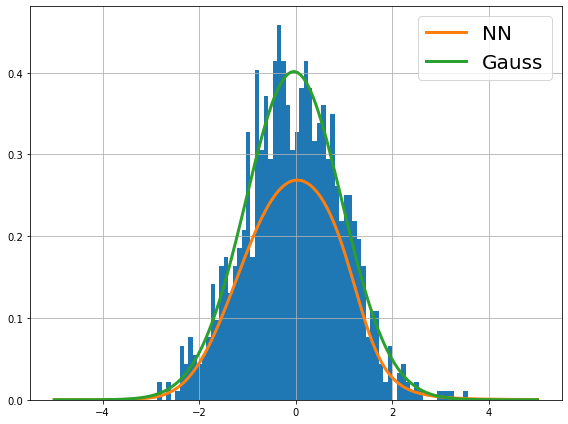

In [18]:
plt.figure(figsize=(8,6))
x = np.linspace(-5, 5, 150).reshape(-1, 1)
plt.hist(data_nn[:,0], bins=70, density=True);
plt.plot(x, optimizer_nn.target(x), linewidth=3, label='NN');
plt.plot(x, optimizer_gauss.target(x), linewidth=3, label='Gauss');
plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()

Serialize the model

In [22]:
@flax.struct.dataclass
class TrainState:
    optimizer: optim.Optimizer

In [24]:
with open('nn_norm.dat', 'wb') as ofile:
    state = TrainState(optimizer=optimizer_nn)
    data = flax.serialization.to_bytes(state)
    print(f'num bytes: {len(data)}')
    ofile.write(data)

num bytes: 14388


deserialize model

In [27]:
with open('nn_norm.dat', 'rb') as ifile:
    data = ifile.read()
    restored_state = flax.serialization.from_bytes(state, data)

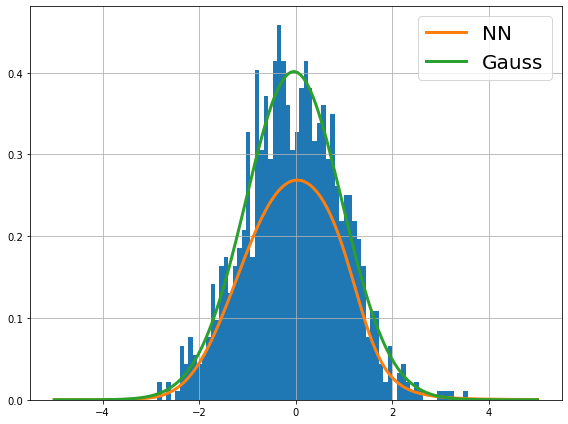

In [34]:
plt.figure(figsize=(8,6))
x = np.linspace(-5, 5, 150).reshape(-1, 1)
plt.hist(data_nn[:,0], bins=70, density=True);
plt.plot(x, restored_state.optimizer.target(x), linewidth=3, label='NN');
plt.plot(x, optimizer_gauss.target(x), linewidth=3, label='Gauss');
plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()